

## Loading the MNIST Handwritten Digit Dataset.



In [0]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt

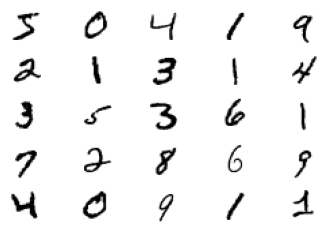

In [41]:
#load the images into memory
(trainX,trainY),(testX,testY)=load_data()
#plot some images from the training dataset
for i in range(25):
  #define subplot
  plt.subplot(5,5,1+i)
  #turn off axis
  plt.axis('off')
  #plot pixel data
  plt.imshow(trainX[i],cmap='gray_r')
plt.show()

# Define and train the Discriminator Model


In [0]:
import numpy as np
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.layers import BatchNormalization
 

In [0]:
#define the discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model=Sequential()
  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model



In [0]:
#prepare mnist training images
def load_real_samples():
  #expand to 3d, add channels dimension
  X=np.expand_dims(trainX,axis=-1)
  #convert from ints to floats
  X=X.astype('float32')
  #scale 
  X=X/255.0
  return X

In [0]:
#select real samples
def generate_real_samples(dataset,n_samples):
  #choose random stances
  ix=np.random.randint(0,dataset.shape[0],n_samples)
  #retrieve selected images
  X=dataset[ix]
  #generate 'real' class labels(1)
  y=np.ones((n_samples,1))
  return X,y

In [0]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
  #generate unifrom random numbers in [0,1]
  X=np.random.rand(28*28*n_samples)
  #reshape into a batch of grayscale images
  X=X.reshape((n_samples,28,28,1))
  #generate 'fake' class labels(0)
  y=np.zeros((n_samples,1))
  return X,y


In [0]:
#train the discriminator model
def train_discriminator(model,dataset,n_iter=100,n_batch=256):
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected 'real' samples
    X_real,y_real=generate_real_samples(dataset,half_batch)
    #update discriminator on real samples
    _,real_acc=model.train_on_batch(X_real,y_real)
    #generate 'fake' examples
    X_fake,y_fake=generate_fake_samples(half_batch)
    #update discriminator on fake samples
    _,fake_acc=model.train_on_batch(X_fake,y_fake)
    #sumamrize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1,real_acc*100,fake_acc*100))

In [48]:
#define the discriminator model
dmodel=define_discriminator()
#load image data
dataset=load_real_samples()
#fit the model
train_discriminator(dmodel,dataset)

>1 real=41% fake=25%
>2 real=53% fake=42%
>3 real=46% fake=58%
>4 real=53% fake=73%
>5 real=48% fake=92%
>6 real=57% fake=93%
>7 real=52% fake=95%
>8 real=52% fake=100%
>9 real=56% fake=98%
>10 real=51% fake=99%
>11 real=51% fake=100%
>12 real=60% fake=100%
>13 real=61% fake=100%
>14 real=62% fake=100%
>15 real=55% fake=100%
>16 real=71% fake=100%
>17 real=56% fake=100%
>18 real=68% fake=100%
>19 real=68% fake=100%
>20 real=70% fake=100%
>21 real=76% fake=100%
>22 real=80% fake=100%
>23 real=85% fake=100%
>24 real=73% fake=100%
>25 real=86% fake=100%
>26 real=87% fake=100%
>27 real=88% fake=100%
>28 real=91% fake=100%
>29 real=92% fake=100%
>30 real=96% fake=100%
>31 real=97% fake=100%
>32 real=98% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=99% fake=100%
>36 real=98% fake=100%
>37 real=99% fake=100%
>38 real=99% fake=100%
>39 real=98% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=100%


# Define and use the Generator Model


In [0]:
#define the generator model
def define_generator(latent_dim):
  model=Sequential()
  #foundation for a 7x7 image
  n_nodes=128*7*7
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  #upsample to 14x14
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #upsample to 28x28
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1,(7,7),activation='sigmoid',padding='same'))
  return model

In [0]:
#generate points in latent space as input for generator
def generate_latent_points(latent_dim,n_samples):
  #generate pnts in latent space
  X_input=np.random.randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  X_input=X_input.reshape(n_samples,latent_dim)
  return X_input


In [0]:
#generate n fake examples with class labels
def generator_fake_samples(g_model,latent_dim,n_samples):
  #generate points in latent space
  x_input=generate_latent_points(latent_dim,n_samples)
  #predict outputs
  X=g_model.predict(x_input)
  #create 'fake' class labels(0)
  y=np.zeros((n_samples,1))
  return X,y

In [0]:
#size of latent space=100
latent_dim=100
#define generator model
gmodel=define_generator(latent_dim)
#generate samples
n_samples=25
X,_ =generator_fake_samples(gmodel,latent_dim,n_samples)


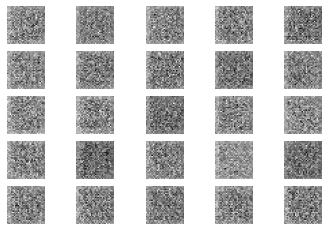

In [61]:
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

# Train the  model

In [0]:
# define the combined generator and discriminator model,for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable=False
  #connect the generator and discriminator models
  model=Sequential()
  model.add(g_model)
  model.add(d_model)
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model 

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 28, 28, 1)         1190401   
_________________________________________________________________
sequential_29 (Sequential)   (None, 1)                 40705     
Total params: 1,231,106
Trainable params: 1,177,345
Non-trainable params: 53,761
_________________________________________________________________


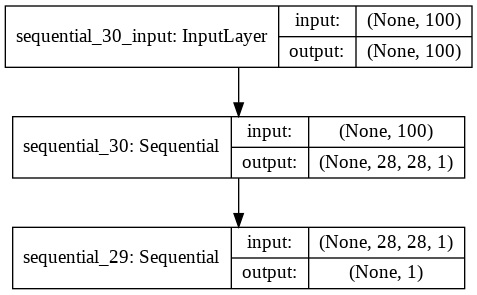

In [63]:
latent_dim=100
#reinitialising the models
d_model = define_discriminator()
g_model = define_generator(latent_dim)
#create the gan
gan_model=define_gan(g_model,d_model)
gan_model.summary()
plot_model(gan_model,to_file='gan_plot.png',show_shapes=True,show_layer_names=True)

In [0]:
#create and save a plot of generated images
def save_plot(examples,epoch,n=10):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0],cmap='gray_r')
  #save plot to file
  filename='gen_plot_%03d.png'%(epoch+10)
  plt.savefig(filename)
  plt.close()

In [0]:
#evaluate the discriminator,p plot generated images,save generator model
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=100):
  #prepare real samples and evaluate discriminator on real examples
  X_real,y_real=generate_real_samples(dataset,n_samples)
  _,acc_real=d_model.evaluate(X_real,y_real,verbose=0)
  #prepare fake examples and evaluate discriminator on fake examples
  X_fake,y_fake=generator_fake_samples(g_model,latent_dim,n_samples)
  _,acc_fake=d_model.evaluate(X_fake,y_fake,verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
  save_plot(X_fake, epoch)
	# save the generator model tile file
  filename = 'gen_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)



In [0]:
#train the generator and discriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=256):
  bat_per_epo=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      #get randomly selected 'real' samples
      X_real,y_real=generate_real_samples(dataset,half_batch)
      #generate 'fake' examples
      X_fake,y_fake=generator_fake_samples(g_model, latent_dim, half_batch)
      #create training set for the discriminator
      X,y=np.vstack((X_real,X_fake)),np.vstack((y_real,y_fake))
      #update discriminator model weights
      d_loss,_=d_model.train_on_batch(X,y)
      #prepare points in latent space
      X_gan=generate_latent_points(latent_dim,n_batch)
      #create inverted labels for the fake samples
      y_gan=np.ones((n_batch,1))
      #update the generator via the discriminator's error
      g_loss=gan_model.train_on_batch(X_gan,y_gan)
      # summarize loss on this batch
      if (j)%50==0:
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    #evaluate model performance
    summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [67]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/234, d=0.710, g=0.676
>1, 51/234, d=0.203, g=0.172
>1, 101/234, d=0.142, g=0.000
>1, 151/234, d=0.056, g=0.000
>1, 201/234, d=0.025, g=0.000
>Accuracy real: 100%, fake: 99%
>2, 1/234, d=0.033, g=0.000
>2, 51/234, d=0.171, g=0.000
>2, 101/234, d=0.301, g=0.000
>2, 151/234, d=0.363, g=0.000
>2, 201/234, d=0.717, g=0.147
>Accuracy real: 36%, fake: 98%
>3, 1/234, d=0.639, g=0.212
>3, 51/234, d=0.861, g=0.592
>3, 101/234, d=0.764, g=0.632
>3, 151/234, d=0.732, g=0.645
>3, 201/234, d=0.738, g=0.656
>Accuracy real: 7%, fake: 51%
>4, 1/234, d=0.739, g=0.684
>4, 51/234, d=0.711, g=0.660
>4, 101/234, d=0.711, g=0.686
>4, 151/234, d=0.707, g=0.696
>4, 201/234, d=0.702, g=0.707
>Accuracy real: 17%, fake: 89%
>5, 1/234, d=0.701, g=0.690
>5, 51/234, d=0.692, g=0.649
>5, 101/234, d=0.701, g=0.690
>5, 151/234, d=0.691, g=0.676
>5, 201/234, d=0.697, g=0.687
>Accuracy real: 97%, fake: 19%
>6, 1/234, d=0.681, g=0.660
>6, 51/234, d=0.705, g=0.700
>6, 101/234, d=0.693, g=0.717
>6, 151/234, d=0.694, g

## Generate images


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


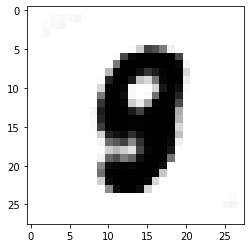

In [68]:
from keras.models import load_model

#laod model
model=load_model('gen_model_100.h5')
#all 0s
vector=np.asarray([[0.0 for _ in range(100)]])
#generate image and plot
X=model.predict(vector)
plt.imshow(X[0,:,:,0],cmap='gray_r')
plt.show()


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


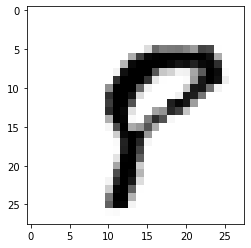

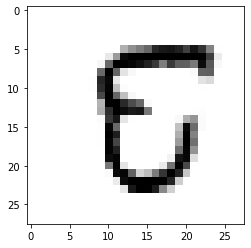

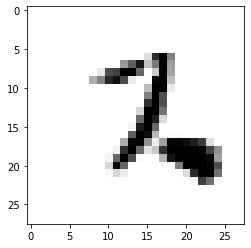

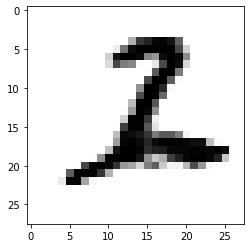

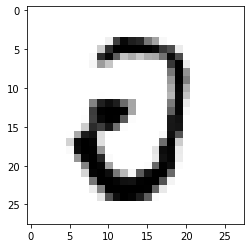

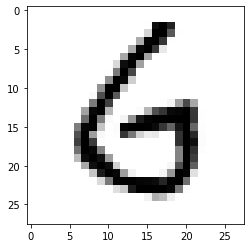

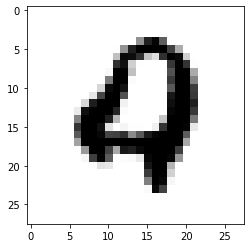

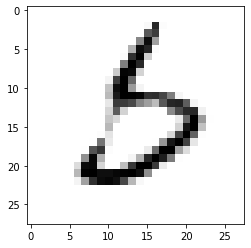

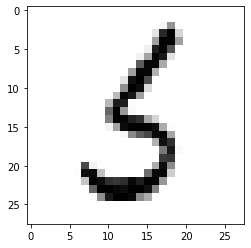

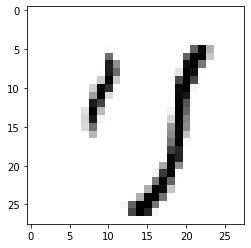

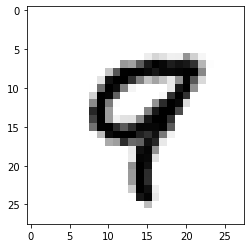

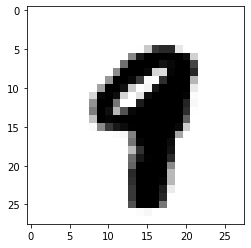

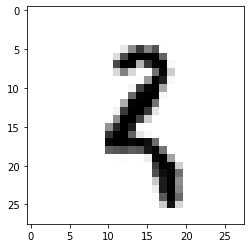

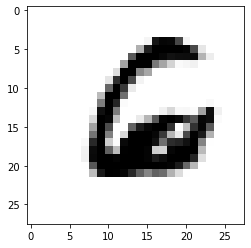

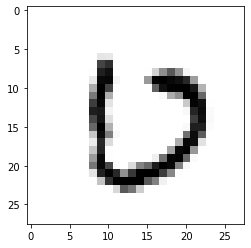

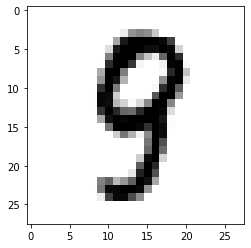

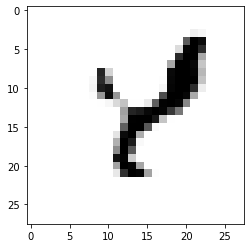

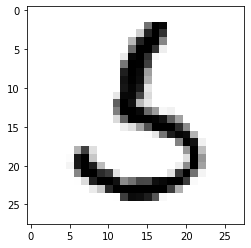

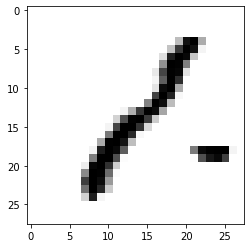

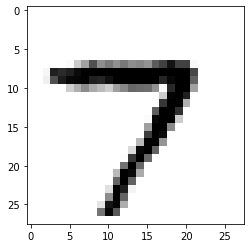

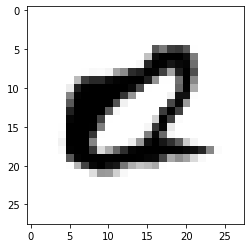

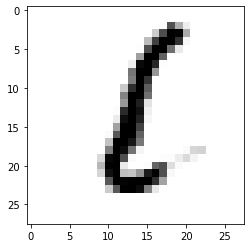

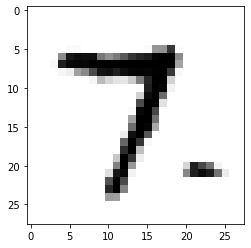

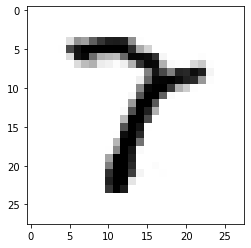

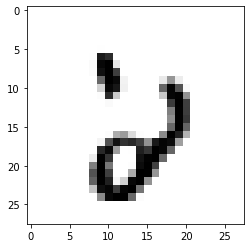

In [75]:
#laod model
model=load_model('gen_model_100.h5')
latent_points=generate_latent_points(100,25)
#generate image and plot
X=model.predict(latent_points)
for i in range(25):
  plt.imshow(X[i,:,:,0],cmap='gray_r')
  plt.show()

## Extensions

TanH Activation and Scaling. Update the example to use the tanh activation function in the generator and scale all pixel values to the range [-1, 1].

**1.Change Latent Space.** Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.

**2.Batch Normalization.** Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.

**3.Label Smoothing.** Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9, and review the effects on image quality and speed of training.

**4.Model Configuration.** Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.

